In [1]:
from call_nlp_api import *
from google.cloud import bigquery
import pandas_gbq
import pandas as pd
import numpy as np

import warnings
warnings.simplefilter("always", category=PendingDeprecationWarning) 
warnings.simplefilter("always", category=DeprecationWarning) 

In [2]:
bq_client = bigquery.Client(location="US", project="ut-goog")
query = """
  SELECT * FROM `nl_api.sentiment_data`
  """
dataset = "nl_api"
table = "nl_api_data"

# Load queries into dataframe and load review checkpoints.
sentimentdf = load_query_results_to_df(bq_client, query)

Query results loaded into dataframe!


In [3]:
sentimentdf.head()

,consumer_complaint_narrative,sentiment_score,sentiment_magnitude
complaint_id,,,
2018855,I am receiving this call 3 times a day maybe 5...,0.0,0.0
2327712,This agency called my brother and sister multi...,0.0,0.0
2428380,"I need a lower payment, deferment or forbearan...",0.0,0.0
1693572,"XXXX times per day, sometimes several differen...",0.0,0.0
2482532,Company making calls within one minute of each...,0.0,0.0


In [4]:
query = """
  SELECT 
    *
  FROM `bigquery-public-data.cfpb_complaints.complaint_database`
  WHERE consumer_complaint_narrative IS NOT NULL;
"""

# Load queries into dataframe and load complaint checkpoints.
df = load_query_results_to_df(bq_client, query)
df.head()

Query results loaded into dataframe!


,date_received,product,subproduct,issue,subissue,consumer_complaint_narrative,company_public_response,company_name,state,zip_code,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed
complaint_id,,,,,,,,,,,,,,,,,
1669847,2015-11-24,Prepaid card,General purpose card,Fees,None,I was given XXXX ( XXXX ) XXXX gift cards ( {$...,Company chooses not to provide a public response,U.S. BANCORP,GA,303XX,None,Consent provided,Web,2015-11-30,Closed with explanation,True,False
1923692,2016-05-14,Prepaid card,General purpose card,Fees,None,I was trying to use my Paypal Prepaid Debit Ca...,Company believes it acted appropriately as aut...,NETSPEND CORPORATION,NJ,070XX,None,Consent provided,Web,2016-05-30,Closed with explanation,True,False
1716861,2015-12-24,Prepaid card,General purpose card,Fees,None,Without receiving any notification that my acc...,Company chooses not to provide a public response,U.S. BANCORP,NC,287XX,None,Consent provided,Web,2015-12-29,Closed with explanation,True,False
2069738,2016-08-18,Prepaid card,General purpose card,Fees,None,I received a {$60.00} prepaid card as a rebate...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",RI,029XX,None,Consent provided,Web,2016-08-22,Closed with explanation,True,True
1739173,2016-01-12,Prepaid card,Gift or merchant card,Fees,None,I just tried to use the remaining balance on m...,Company chooses not to provide a public response,"CITIBANK, N.A.",AL,358XX,None,Consent provided,Web,2016-01-14,Closed with explanation,True,False


In [ ]:
query = """
  SELECT
  complaint_id,
  consumer_complaint_narrative,
  entities.item AS entity,
  entity_types.item AS entity_type
  FROM
  `ut-goog.nl_api.entity_data` AS data,
  UNNEST(data.entities.list) AS entities,
  UNNEST(data.entity_types.list) AS entity_types
  -- extract sentiment score and magnitude using this same UNNEST pattern
  WITH OFFSET AS offset
  ORDER BY offset
  """

# Load queries into dataframe and load review checkpoints.
entity2df = load_query_results_to_df(bq_client, query) 

# This is not working for some reason!
# The error I get when I try to access the sql in json formart is:
# ArrowNotImplementedError: Not implemented type for lists: struct<item: string>
# Have changed this to the unpacked SQL query now

In [5]:
# This is just to get the job done
entitydf = pd.read_csv("entity_data.csv")
entitydf.head()

,complaint_id,consumer_complaint_narrative,entities,entity_types,entity_sentiment_scores,entity_sentiment_magnitudes
0,2824350,DBA of transaction says dr due to ATM/DEP erro...,"['transaction', 'DBA', 'dr', 'error', 'XX/XX',...","['OTHER', 'OTHER', 'PERSON', 'OTHER', 'OTHER',...","[0, 0, 0, -0.699999988079071, -0.1000000014901...","[0, 0, 0, 0.699999988079071, 0.100000001490116..."
1,2051787,They cal upwards of 15 times a day.,['times'],['OTHER'],[0],[0]
2,3418791,Alot of hard impacts are effecting my credit.,"['Alot', 'impacts', 'credit']","['OTHER', 'OTHER', 'OTHER']","[-0.5, -0.6000000238418579, 0]","[0.5, 0.6000000238418579, 0]"
3,2560181,XXXX {$510.00} DISPUTED LETTERS SEVERAL TIMES ...,"['LETTERS', 'XXXX', 'TIMES XXXX', 'TIMES']","['WORK_OF_ART', 'ORGANIZATION', 'PERSON', 'OTH...","[-0.20000000298023224, -0.30000001192092896, -...","[0.5, 0.30000001192092896, 0.10000000149011612..."
4,2684583,My interest has compounded to the point I can ...,"['interest', 'point', 'loans']","['OTHER', 'OTHER', 'OTHER']","[-0.5, -0.10000000149011612, 0]","[0.5, 0.10000000149011612, 0]"


In [ ]:
entity2df.head()

In [189]:
entitydf['complaint_id'] = entitydf['complaint_id'].astype('object')

In [52]:
entitydf['complaint_id'].dtypes

dtype('O')

In [ ]:
mainsentimentdf = df.merge(sentimentdf, on='complaint_id', how='left')
mainsentimentdf.head()

## !!!I did manage to get the SQL join working but is this the right way to join the tables, pull in a merged table into pandas and then write it back to BQ or is there a quicker way to get around this?

In [25]:
query = """
    SELECT table1.*, table2.sentiment_score, table2.sentiment_magnitude
    FROM `bigquery-public-data.cfpb_complaints.complaint_database` as table1
    JOIN `nl_api.sentiment_data` as table2
    ON cast(table1.complaint_id as int64) = table2.complaint_id
    WHERE table1.consumer_complaint_narrative IS NOT NULL;
  """

# Load queries into dataframe and load review checkpoints.
merge2df = load_query_results_to_df(bq_client, query) 
merge2df.head()

Query results loaded into dataframe!


,date_received,product,subproduct,issue,subissue,consumer_complaint_narrative,company_public_response,company_name,state,zip_code,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed,sentiment_score,sentiment_magnitude
complaint_id,,,,,,,,,,,,,,,,,,,
1669847,2015-11-24,Prepaid card,General purpose card,Fees,None,I was given XXXX ( XXXX ) XXXX gift cards ( {$...,Company chooses not to provide a public response,U.S. BANCORP,GA,303XX,None,Consent provided,Web,2015-11-30,Closed with explanation,True,False,-0.2,4.6
1923692,2016-05-14,Prepaid card,General purpose card,Fees,None,I was trying to use my Paypal Prepaid Debit Ca...,Company believes it acted appropriately as aut...,NETSPEND CORPORATION,NJ,070XX,None,Consent provided,Web,2016-05-30,Closed with explanation,True,False,-0.5,3.9
1716861,2015-12-24,Prepaid card,General purpose card,Fees,None,Without receiving any notification that my acc...,Company chooses not to provide a public response,U.S. BANCORP,NC,287XX,None,Consent provided,Web,2015-12-29,Closed with explanation,True,False,-0.5,1.5
2069738,2016-08-18,Prepaid card,General purpose card,Fees,None,I received a {$60.00} prepaid card as a rebate...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",RI,029XX,None,Consent provided,Web,2016-08-22,Closed with explanation,True,True,-0.3,1.4
1739173,2016-01-12,Prepaid card,Gift or merchant card,Fees,None,I just tried to use the remaining balance on m...,Company chooses not to provide a public response,"CITIBANK, N.A.",AL,358XX,None,Consent provided,Web,2016-01-14,Closed with explanation,True,False,-0.7,1.5


In [21]:
mainsentimentdf = mainsentimentdf.reset_index()

In [24]:
mainsentimentdf.head()

,complaint_id,date_received,product,subproduct,issue,subissue,consumer_complaint_narrative_x,company_public_response,company_name,state,...,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed,consumer_complaint_narrative_y,sentiment_score,sentiment_magnitude
0,2164428,2016-10-18,Prepaid card,ID prepaid card,Fees,None,Front of sheet accompanying prepaid card indic...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",CA,...,None,Consent provided,Web,2016-10-20,Closed with monetary relief,True,False,Front of sheet accompanying prepaid card indic...,-0.4,1.9
1,1581265,2015-09-25,Prepaid card,General purpose card,Fees,None,I received XXXX ( XXXX ) USBank Cash+ Bonus Re...,Company chooses not to provide a public response,U.S. BANCORP,CA,...,None,Consent provided,Web,2015-09-29,Closed with monetary relief,True,False,I received XXXX ( XXXX ) USBank Cash+ Bonus Re...,0.0,3.4
2,2224405,2016-11-28,Prepaid card,General purpose card,Fees,None,I received a prepaid debit card from Citi bank...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",FL,...,None,Consent provided,Web,2016-11-29,Closed with explanation,True,False,I received a prepaid debit card from Citi bank...,-0.5,1.7
3,2393868,2017-03-19,Prepaid card,General purpose card,Fees,None,When first opened the account there was a pref...,Company believes it acted appropriately as aut...,NETSPEND CORPORATION,WA,...,None,Consent provided,Web,2017-03-20,Closed with explanation,True,False,When first opened the account there was a pref...,-0.4,2.3
4,1721395,2015-12-31,Prepaid card,Mobile wallet,Fees,None,In the process of making a purchase over the i...,None,"Paypal Holdings, Inc",NM,...,None,Consent provided,Web,2016-01-05,Closed with explanation,True,False,In the process of making a purchase over the i...,-0.4,1.3


In [31]:
mainsentimentdf.shape

(496719, 21)

In [34]:
mainsentimentdf['complaint_id'] = mainsentimentdf['complaint_id'].astype('object')

In [53]:
mainsentimentdf['complaint_id'].dtypes

dtype('O')

In [37]:
entitydf[entitydf['complaint_id']==2164428]

,complaint_id,consumer_complaint_narrative,entities,entity_types,entity_sentiment_scores,entity_sentiment_magnitudes
458534,2164428,Front of sheet accompanying prepaid card indic...,"['prepaid card', 'sheet', 'Front', ""XX/XX/XXXX...","['OTHER', 'OTHER', 'OTHER', 'OTHER', 'PERSON',...","[-0.4000000059604645, -0.10000000149011612, -0...","[0.4000000059604645, 0.10000000149011612, 0.10..."


In [54]:
mergedf = pd.DataFrame()
mergedf = mainsentimentdf.merge(entitydf, on='complaint_id', how='left')

In [55]:
mergedf.head()

,complaint_id,date_received,product,subproduct,issue,subissue,consumer_complaint_narrative_x,company_public_response,company_name,state,...,timely_response,consumer_disputed,consumer_complaint_narrative_y,sentiment_score,sentiment_magnitude,consumer_complaint_narrative,entities,entity_types,entity_sentiment_scores,entity_sentiment_magnitudes
0,2164428,2016-10-18,Prepaid card,ID prepaid card,Fees,None,Front of sheet accompanying prepaid card indic...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",CA,...,True,False,Front of sheet accompanying prepaid card indic...,-0.4,1.9,Front of sheet accompanying prepaid card indic...,"['prepaid card', 'sheet', 'Front', ""XX/XX/XXXX...","['OTHER', 'OTHER', 'OTHER', 'OTHER', 'PERSON',...","[-0.4000000059604645, -0.10000000149011612, -0...","[0.4000000059604645, 0.10000000149011612, 0.10..."
1,1581265,2015-09-25,Prepaid card,General purpose card,Fees,None,I received XXXX ( XXXX ) USBank Cash+ Bonus Re...,Company chooses not to provide a public response,U.S. BANCORP,CA,...,True,False,I received XXXX ( XXXX ) USBank Cash+ Bonus Re...,0.0,3.4,I received XXXX ( XXXX ) USBank Cash+ Bonus Re...,"['Bonus Rewards Cards', 'USBank', 'XXXX', 'mai...","['OTHER', 'ORGANIZATION', 'ORGANIZATION', 'OTH...","[-0.10000000149011612, 0, 0, 0, -0.20000000298...","[0.10000000149011612, 0.30000001192092896, 0.1..."
2,2224405,2016-11-28,Prepaid card,General purpose card,Fees,None,I received a prepaid debit card from Citi bank...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",FL,...,True,False,I received a prepaid debit card from Citi bank...,-0.5,1.7,I received a prepaid debit card from Citi bank...,"['debit card', 'Citi', 'bank', 'reward', 'XXXX...","['OTHER', 'ORGANIZATION', 'ORGANIZATION', 'OTH...","[0, 0.10000000149011612, 0, -0.300000011920928...","[0.20000000298023224, 0.10000000149011612, 0, ..."
3,2393868,2017-03-19,Prepaid card,General purpose card,Fees,None,When first opened the account there was a pref...,Company believes it acted appropriately as aut...,NETSPEND CORPORATION,WA,...,True,False,When first opened the account there was a pref...,-0.4,2.3,When first opened the account there was a pref...,"['account', 'fee plan', 'preference', 'transac...","['OTHER', 'OTHER', 'OTHER', 'OTHER', 'OTHER', ...","[-0.20000000298023224, -0.5, -0.40000000596046...","[0.20000000298023224, 0.5, 0.4000000059604645,..."
4,1721395,2015-12-31,Prepaid card,Mobile wallet,Fees,None,In the process of making a purchase over the i...,None,"Paypal Holdings, Inc",NM,...,True,False,In the process of making a purchase over the i...,-0.4,1.3,In the process of making a purchase over the i...,"['purchase', 'process', 'internet', 'commerce ...","['EVENT', 'OTHER', 'OTHER', 'OTHER', 'ORGANIZA...","[0, 0.20000000298023224, 0, -0.100000001490116...","[0, 0.20000000298023224, 0, 0.1000000014901161..."


In [56]:
mergedf.shape

(496719, 26)

In [59]:
mergedf = mergedf.drop(['consumer_complaint_narrative_y','consumer_complaint_narrative'],axis=1)

In [60]:
mergedf.rename(columns = {'consumer_complaint_narrative_x':'consumer_complaint_narrative'}, inplace = True) 

In [61]:
mergedf.head()

,complaint_id,date_received,product,subproduct,issue,subissue,consumer_complaint_narrative,company_public_response,company_name,state,...,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed,sentiment_score,sentiment_magnitude,entities,entity_types,entity_sentiment_scores,entity_sentiment_magnitudes
0,2164428,2016-10-18,Prepaid card,ID prepaid card,Fees,None,Front of sheet accompanying prepaid card indic...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",CA,...,2016-10-20,Closed with monetary relief,True,False,-0.4,1.9,"['prepaid card', 'sheet', 'Front', ""XX/XX/XXXX...","['OTHER', 'OTHER', 'OTHER', 'OTHER', 'PERSON',...","[-0.4000000059604645, -0.10000000149011612, -0...","[0.4000000059604645, 0.10000000149011612, 0.10..."
1,1581265,2015-09-25,Prepaid card,General purpose card,Fees,None,I received XXXX ( XXXX ) USBank Cash+ Bonus Re...,Company chooses not to provide a public response,U.S. BANCORP,CA,...,2015-09-29,Closed with monetary relief,True,False,0.0,3.4,"['Bonus Rewards Cards', 'USBank', 'XXXX', 'mai...","['OTHER', 'ORGANIZATION', 'ORGANIZATION', 'OTH...","[-0.10000000149011612, 0, 0, 0, -0.20000000298...","[0.10000000149011612, 0.30000001192092896, 0.1..."
2,2224405,2016-11-28,Prepaid card,General purpose card,Fees,None,I received a prepaid debit card from Citi bank...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",FL,...,2016-11-29,Closed with explanation,True,False,-0.5,1.7,"['debit card', 'Citi', 'bank', 'reward', 'XXXX...","['OTHER', 'ORGANIZATION', 'ORGANIZATION', 'OTH...","[0, 0.10000000149011612, 0, -0.300000011920928...","[0.20000000298023224, 0.10000000149011612, 0, ..."
3,2393868,2017-03-19,Prepaid card,General purpose card,Fees,None,When first opened the account there was a pref...,Company believes it acted appropriately as aut...,NETSPEND CORPORATION,WA,...,2017-03-20,Closed with explanation,True,False,-0.4,2.3,"['account', 'fee plan', 'preference', 'transac...","['OTHER', 'OTHER', 'OTHER', 'OTHER', 'OTHER', ...","[-0.20000000298023224, -0.5, -0.40000000596046...","[0.20000000298023224, 0.5, 0.4000000059604645,..."
4,1721395,2015-12-31,Prepaid card,Mobile wallet,Fees,None,In the process of making a purchase over the i...,None,"Paypal Holdings, Inc",NM,...,2016-01-05,Closed with explanation,True,False,-0.4,1.3,"['purchase', 'process', 'internet', 'commerce ...","['EVENT', 'OTHER', 'OTHER', 'OTHER', 'ORGANIZA...","[0, 0.20000000298023224, 0, -0.100000001490116...","[0, 0.20000000298023224, 0, 0.1000000014901161..."


In [62]:
table_name = "merged_data_with_sentiments"
mergedf.index = mergedf.index.astype(int)
dataset = bq_client.dataset(dataset)
table_ref = dataset.table(table_name)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: PendingDeprecationWarning: Client.dataset is deprecated and will be removed in a future version. Use a string like 'my_project.my_dataset' or a cloud.google.bigquery.DatasetReference object, instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [66]:
job_config = bigquery.LoadJobConfig()
job_config.write_disposition = "WRITE_TRUNCATE"
job = bq_client.load_table_from_dataframe(mergedf, table_ref, location="US",
                                            job_config=job_config)
job.result()
assert job.state == "DONE"
print("BQ table updated:", table_name)

BQ table updated: merged_data_with_sentiments


In [67]:
mergedf.to_csv('merged_data_with_sentiments.csv')

### EDA phase:

In [68]:
(mergedf.isnull().sum()/len(mergedf)*100).sort_values(ascending=False)

tags                            82.897977
consumer_disputed               66.969856
company_public_response         51.265404
subissue                        25.903579
zip_code                        22.440253
subproduct                      10.503323
state                            0.383114
entity_sentiment_scores          0.106499
entity_sentiment_magnitudes      0.106499
sentiment_score                  0.106499
sentiment_magnitude              0.106499
entities                         0.106499
entity_types                     0.106499
company_response_to_consumer     0.000201
date_sent_to_company             0.000000
submitted_via                    0.000000
consumer_consent_provided        0.000000
timely_response                  0.000000
company_name                     0.000000
consumer_complaint_narrative     0.000000
issue                            0.000000
product                          0.000000
date_received                    0.000000
complaint_id                     0

In [69]:
(sentimentdf.isnull().sum()/len(sentimentdf)*100).sort_values(ascending=False)

sentiment_magnitude             0.0
sentiment_score                 0.0
consumer_complaint_narrative    0.0
dtype: float64

In [70]:
(entitydf.isnull().sum()/len(entitydf)*100).sort_values(ascending=False)

entity_sentiment_magnitudes     0.0
entity_sentiment_scores         0.0
entity_types                    0.0
entities                        0.0
consumer_complaint_narrative    0.0
complaint_id                    0.0
dtype: float64

In [73]:
sentimentdf.describe()

,sentiment_score,sentiment_magnitude
count,496191.000000,496191.000000
mean,-0.368554,4.029757
std,0.224258,4.132080
min,-0.900000,0.000000
25%,-0.500000,1.500000
50%,-0.300000,2.900000
75%,-0.200000,5.200000
max,0.900000,172.000000


In [74]:
entitydf.describe()

,complaint_id,consumer_complaint_narrative,entities,entity_types,entity_sentiment_scores,entity_sentiment_magnitudes
count,496191,496191,496191,496191,496191,496191
unique,496191,467640,458788,385198,443565,444611
top,3413733,There are many mistakes appear in my report wi...,"['mistakes', 'report', 'understanding']","['OTHER', 'OTHER']","[-0.8999999761581421, 0, -0.30000001192092896]","[0.8999999761581421, 0, 0.30000001192092896]"
freq,1,1035,1036,2872,1045,1042


#### It was noticed that a lot of rows had both sentiment score and magnitude as 0. ??

In [85]:
sentimentdf[(sentimentdf['sentiment_score'] == 0) & (sentimentdf['sentiment_magnitude']== 0)]

,consumer_complaint_narrative,sentiment_score,sentiment_magnitude
complaint_id,,,
2018855,I am receiving this call 3 times a day maybe 5...,0.0,0.0
2327712,This agency called my brother and sister multi...,0.0,0.0
2428380,"I need a lower payment, deferment or forbearan...",0.0,0.0
1693572,"XXXX times per day, sometimes several differen...",0.0,0.0
2482532,Company making calls within one minute of each...,0.0,0.0
...,...,...,...
1503030,I have a USAA charged off that 's being report...,0.0,0.0
1617594,I have had a debt consolidation company issue ...,0.0,0.0
3426795,Department of Education continues to increase ...,0.0,0.0


In [91]:
sentimentdf[(sentimentdf['sentiment_score'] == 0) & (sentimentdf['sentiment_magnitude']== 0)]['consumer_complaint_narrative'].values

array(['I am receiving this call 3 times a day maybe 5 days a week from XXXX different numbers. They are trying to collect on a debt double the amount that is owed.',
       'This agency called my brother and sister multiple times instead of me in order to try and get in touch with me. They should have already had my contact information.',
       'I need a lower payment, deferment or forbearance!! I can not repay these loans as of yet!!',
       ...,
       'Department of Education continues to increase payments on credit file. Currently enrolled in XXXX XXXX XXXX XXXX XXXX. Account is currently in Forbearance. Made several Attempts to resolve with company.',
       'Contacted branches investigation departments as well as the Social security administration for protection and to report abuse, the abuse is currently still ongoing, in which has now affected my children.',
       'XXXX is reporting a single late payment over 7 years old to my credit report.'],
      dtype=object)

##### As expected most of the sentiments are negative because we are looking at complaints data

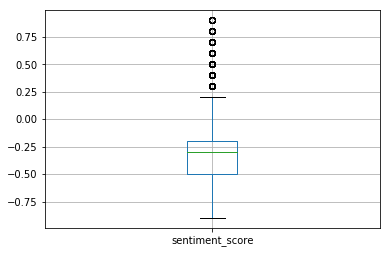

In [105]:
mergedf['sentiment_score'].plot.box(grid='True')

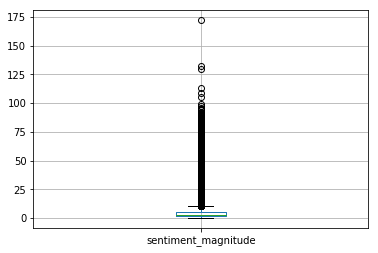

In [106]:
mergedf['sentiment_magnitude'].plot.box(grid='True')

#### Companies with the best average sentiment

In [176]:
query = """
    SELECT 
        company_name, AVG(sentiment_score) as average_sentiment, COUNT(complaint_id) as number_of_complaints
    FROM 
        `nl_api.merged_data_with_sentiments`
    GROUP BY
        company_name
    ORDER BY
        average_sentiment DESC
"""
query_job = bq_client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

companies_sentiment_df = query_job.to_dataframe()
companies_sentiment_df[:15]

,company_name,average_sentiment,number_of_complaints
0,"General Collections & Recoveries, Inc.",0.70,1
1,Contemporary Recovery Solutions Inc.,0.40,1
2,"National Bureau of Collections, Inc",0.30,1
3,TFLC Trust,0.20,1
4,"The Student Loan Project, Inc.",0.20,1
5,"LoanLeaders of America, Inc.",0.15,2
6,Regional Mediation Associates LLC,0.15,2
7,JPL Recovery LLC,0.10,2
8,Elite Student Solutions,0.10,1
9,A.I.T. Credit Services Inc.,0.10,1


In [149]:
# Checking company with the highest sentiment score
mergedf[mergedf['company_name']=='General Collections & Recoveries, Inc.'] 
# Possible outlier because the individual entity sentiment score is 0

,complaint_id,date_received,product,subproduct,issue,subissue,consumer_complaint_narrative,company_public_response,company_name,state,...,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed,sentiment_score,sentiment_magnitude,entities,entity_types,entity_sentiment_scores,entity_sentiment_magnitudes
200123,2876523,2018-04-16,Debt collection,Medical debt,Written notification about debt,Didn't receive enough information to verify debt,Would like to know how i owe this debt,None,"General Collections & Recoveries, Inc.",MN,...,2018-09-24,Closed with explanation,True,None,0.7,0.7,['debt'],['OTHER'],[0],[0]


In [1]:
mergedf[mergedf['company_name']=='Contemporary Recovery Solutions Inc.'] 

NameError: name 'mergedf' is not defined

In [162]:
# Checking the company with the second highest sentiment score. The comment looks bad for the score of 0.4
mergedf[mergedf['company_name']=='Contemporary Recovery Solutions Inc.']['consumer_complaint_narrative'].values

array(['Harrassing me at work, telling my co-workers that I have a legal issue ... ..that I need to call ....'],
      dtype=object)

#### Companies with the worst average sentiments

In [169]:
companies_sentiment_df[-35:] # 34 companies have the lowest sentiment score

,company_name,average_sentiment,number_of_complaints
4414,"The Accounts Retrievable System, Inc.",-0.8,1
4415,"REPORTS, INC.",-0.9,1
4416,Car Cage Motors Inc,-0.9,1
4417,Cunningham Law Inc.,-0.9,1
4418,Diversified Company,-0.9,1
4419,Kitch Acceptance Corp.,-0.9,1
4420,"Three B Financial, LLC",-0.9,1
4421,First Mortgage Solutions,-0.9,1
4422,"Economic Recovery Consultants, Inc",-0.9,1
4423,"Crescent City Credit Recovery, Inc.",-0.9,1


#### ^This number shows that the companies with the lowest sentiment had just one complaint per head with poor comments

In [146]:
# Another way to check that these companies only have one complaint against them
mergedf[mergedf['company_name'].isin(companies_low_sentiment)]['company_name'].nunique() 

34

### Sentiment check on an issue and sub issue levels

In [177]:
query = """
    SELECT 
        issue, AVG(sentiment_score) as average_sentiment, COUNT(complaint_id) as number_of_complaints
    FROM 
        `nl_api.merged_data_with_sentiments`
    GROUP BY
        issue
    ORDER BY
        average_sentiment DESC
"""
query_job = bq_client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

issue_sentiment_df = query_job.to_dataframe()
issue_sentiment_df[:15]

,issue,average_sentiment,number_of_complaints
0,Lender damaged or destroyed vehicle,-0.150000,2
1,Property was damaged or destroyed property,-0.200000,2
2,Lender damaged or destroyed property,-0.200000,1
3,Struggling to repay your loan,-0.251265,3560
4,Dealing with your lender or servicer,-0.259970,9343
5,Applying for a mortgage or refinancing an exis...,-0.262158,3106
6,Credit decision / Underwriting,-0.262452,1289
7,Applying for a mortgage,-0.272165,194
8,"Application, originator, mortgage broker",-0.273572,3746
9,Closing on a mortgage,-0.274358,2731


In [165]:
mergedf[mergedf['issue']=='Lender damaged or destroyed vehicle']

,complaint_id,date_received,product,subproduct,issue,subissue,consumer_complaint_narrative,company_public_response,company_name,state,...,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed,sentiment_score,sentiment_magnitude,entities,entity_types,entity_sentiment_scores,entity_sentiment_magnitudes
181291,2383096,2017-03-12,Consumer Loan,Title loan,Lender damaged or destroyed vehicle,None,"As of XXXX / XXXX / XXXX , interest paid on t...",None,Keystone Equipment Finance Corp.,NC,...,2017-06-28,Closed with explanation,True,False,-0.2,2.2,"['interest', 'principal', 'loan', 'XXXX / XXXX...","['OTHER', 'PERSON', 'OTHER', 'OTHER', 'OTHER',...","[0.10000000149011612, 0.20000000298023224, 0, ...","[0.10000000149011612, 0.20000000298023224, 0, ..."
262234,1575774,2015-09-23,Consumer Loan,Title loan,Lender damaged or destroyed vehicle,None,A few years ago I found myself between jobs. I...,None,TMX Finance LLC,TX,...,2015-09-25,Closed with explanation,True,False,-0.1,3.7,"['jobs', 'XXXX XXXX XXXX', 'Auto Title Loan', ...","['OTHER', 'OTHER', 'OTHER', 'CONSUMER_GOOD', '...","[0.10000000149011612, -0.30000001192092896, -0...","[0.10000000149011612, 1.5, 0.10000000149011612..."


In [171]:
issue_sentiment_df[-15:]

,issue,average_sentiment,number_of_complaints
146,"Managing, opening, or closing account",-0.424093,386
147,Unable to get credit report/credit score,-0.424512,2252
148,Unauthorized transactions/trans. issues,-0.425599,543
149,Problem with a credit reporting company's inve...,-0.427693,39967
150,Adding money,-0.428261,92
151,Identity theft / Fraud / Embezzlement,-0.429251,1723
152,Incorrect information on your report,-0.429959,81274
153,Property was sold,-0.433333,3
154,"Was approved for a loan, but didn't receive th...",-0.445070,71
155,Shopping for a line of credit,-0.450000,10


In [167]:
mergedf[mergedf['issue']=='Problem with fraud alerts or security freezes'] # has 3000+ complaints linked to the lowest sentiment issue

,complaint_id,date_received,product,subproduct,issue,subissue,consumer_complaint_narrative,company_public_response,company_name,state,...,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed,sentiment_score,sentiment_magnitude,entities,entity_types,entity_sentiment_scores,entity_sentiment_magnitudes
360730,3115022,2019-01-02,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with fraud alerts or security freezes,None,"Because I was impacted by the Equifax hack, an...",None,"EQUIFAX, INC.",DC,...,2019-01-02,Closed with explanation,True,None,-0.4,2.6,"['social security number', 'Equifax', 'hack', ...","['OTHER', 'ORGANIZATION', 'OTHER', 'PERSON', '...","[0, -0.30000001192092896, -0.30000001192092896...","[0.8999999761581421, 1.2000000476837158, 0.300..."
360731,3182135,2019-03-17,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with fraud alerts or security freezes,None,Identify theft victim ; XXXX XXXX XXXX **Compl...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",GA,...,2019-03-17,Closed with explanation,True,None,-0.5,8.8,"['XXXX', 'XXXX', 'more', 'XXXX XXXX XXXX', 'th...","['OTHER', 'OTHER', 'OTHER', 'CONSUMER_GOOD', '...","[-0.699999988079071, -0.4000000059604645, -0.1...","[2.799999952316284, 0.800000011920929, 0.10000..."
360732,3205462,2019-04-08,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with fraud alerts or security freezes,None,I would like to request the removal of my Cred...,None,LEXISNEXIS,OH,...,2019-04-08,Closed with explanation,True,None,-0.5,1.0,"['Credit Freeze', 'credit reports', 'removal',...","['OTHER', 'OTHER', 'EVENT', 'OTHER', 'ORGANIZA...","[-0.6000000238418579, -0.30000001192092896, -0...","[0.6000000238418579, 0.30000001192092896, 0.5,..."
360733,3235960,2019-05-08,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with fraud alerts or security freezes,None,Temporary lifted security freeze at all 3 cred...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,FL,...,2019-05-08,Closed with explanation,True,None,-0.3,5.2,"['security freeze', 'credit reporting agencies...","['OTHER', 'ORGANIZATION', 'OTHER', 'OTHER', 'O...","[-0.8999999761581421, 0, 0, 0, 0, -0.100000001...","[0.8999999761581421, 0, 0, 0.20000000298023224..."
360734,3353548,2019-08-26,Checking or savings account,Checking account,Problem with fraud alerts or security freezes,None,I have been a victim of identity theft and i h...,None,"Early Warning Services, LLC",OH,...,2019-08-26,Closed with explanation,True,None,-0.4,1.7,"['victim', 'identity theft', 'name', 't', 'rep...","['PERSON', 'OTHER', 'OTHER', 'OTHER', 'WORK_OF...","[-0.10000000149011612, -0.800000011920929, -0....","[1.600000023841858, 0.800000011920929, 0.30000..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460263,3159597,2019-02-22,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with fraud alerts or security freezes,None,Equifax 's website to freeze credit does not h...,None,"EQUIFAX, INC.",HI,...,2019-02-22,Closed with explanation,True,None,-0.3,1.7,"['credit', 'website', 'Equifax', 'button', 'fr...","['OTHER', 'OTHER', 'ORGANIZATION', 'OTHER', 'O...","[-0.800000011920929, -0.4000000059604645, -0.4...","[0.800000011920929, 0.4000000059604645, 0.4000..."
460264,3113946,2019-01-01,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with fraud alerts or security freezes,None,"Four times this year, someone has been able to...",None,CAPITAL ONE FINANCIAL CORPORATION,GA,...,2019-01-07,Closed with explanation,True,None,-0.3,5.8,"['XXXX', 'someone', 'credit card', 'credit car...","['OTHER', 'PERSON', 'OTHER', 'OTHER', 'OTHER',...","[0, -0.4000000059604645, 0, 0, 0, -0.100000001...","[0.4000000059604645, 0.4000000059604645, 0, 0,..."
460265,2880674,2018-04-19,"Credit re

In [178]:
query = """
    SELECT 
        subissue, AVG(sentiment_score) as average_sentiment, COUNT(complaint_id) as number_of_complaints
    FROM 
        `nl_api.merged_data_with_sentiments`
    GROUP BY
        subissue
    ORDER BY
        average_sentiment DESC
"""
query_job = bq_client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

subissue_sentiment_df = query_job.to_dataframe()
subissue_sentiment_df[:15]

,subissue,average_sentiment,number_of_complaints
0,You never received your bill or did not know a...,-0.196281,995
1,Problem lowering your monthly payments,-0.239311,1249
2,Need information about your loan balance or lo...,-0.242379,538
3,Problem when attempting to purchase vehicle at...,-0.245833,48
4,Problem with renewal,-0.250000,16
5,Can't get other flexible options for repaying ...,-0.251575,1877
6,Received bad information about your loan,-0.252785,3359
7,Trouble with how payments are being handled,-0.257068,3252
8,Don't agree with fees charged,-0.258978,1292
9,Need information about my balance/terms,-0.259871,466


In [173]:
subissue_sentiment_df[-15:]

,subissue,average_sentiment,number_of_complaints
202,Their investigation did not fix an error on yo...,-0.434735,28609
203,Reinserted previously deleted info,-0.437377,2028
204,Account opened as a result of fraud,-0.439118,364
205,Was not notified of investigation status or re...,-0.442872,2847
206,Overdraft charges,-0.446154,13
207,Information is not mine,-0.449254,7102
208,Card opened as result of identity theft or fraud,-0.450529,1135
209,Contacted you instead of your attorney,-0.453125,32
210,Credit inquiries on your report that you don't...,-0.456344,13418
211,Report improperly shared by CRC,-0.467138,1415


## Sentiment check on a product level

In [179]:
query = """
    SELECT 
        product, AVG(sentiment_score) as average_sentiment, COUNT(complaint_id) as number_of_complaints
    FROM 
        `nl_api.merged_data_with_sentiments`
    GROUP BY
        product
    ORDER BY
        average_sentiment DESC
"""
query_job = bq_client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

product_sentiment_df = query_job.to_dataframe()
product_sentiment_df[:15]

,product,average_sentiment,number_of_complaints
0,Virtual currency,-0.256250,16
1,Student loan,-0.267051,25186
2,Mortgage,-0.279913,61901
3,Vehicle loan or lease,-0.312074,8283
4,Consumer Loan,-0.316679,9473
5,"Payday loan, title loan, or personal loan",-0.325890,6501
6,Payday loan,-0.332073,1746
7,Other financial service,-0.342466,292
8,Credit card,-0.345737,18838
9,Money transfers,-0.347228,1497


In [180]:
product_sentiment_df[-15:]

,product,average_sentiment,number_of_complaints
3,Vehicle loan or lease,-0.312074,8283
4,Consumer Loan,-0.316679,9473
5,"Payday loan, title loan, or personal loan",-0.325890,6501
6,Payday loan,-0.332073,1746
7,Other financial service,-0.342466,292
8,Credit card,-0.345737,18838
9,Money transfers,-0.347228,1497
10,Credit card or prepaid card,-0.348058,32643
11,"Money transfer, virtual currency, or money ser...",-0.357143,7963
12,Bank account or service,-0.358146,14885


##### Clearly credit reporting, prepaid card and other card related services had the lowest overall sentiment but then they were extremely high in number of complaints too

## Sentiment Check to see effect on company public response

In [183]:
mergedf['company_public_response'].nunique()

10

In [181]:
query = """
    SELECT 
        company_public_response, AVG(sentiment_score) as average_sentiment, COUNT(complaint_id) as number_of_complaints
    FROM 
        `nl_api.merged_data_with_sentiments`
    GROUP BY
        company_public_response
    ORDER BY
        average_sentiment DESC
"""
query_job = bq_client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

response_sentiment_df = query_job.to_dataframe()
response_sentiment_df[:15]

,company_public_response,average_sentiment,number_of_complaints
0,Company believes complaint relates to a discon...,-0.297222,36
1,Company believes complaint is the result of an...,-0.307477,2287
2,Company believes complaint represents an oppor...,-0.331134,1728
3,Company believes the complaint is the result o...,-0.336887,3284
4,Company believes it acted appropriately as aut...,-0.338038,33970
5,Company believes complaint caused principally ...,-0.338790,2298
6,Company chooses not to provide a public response,-0.346271,19818
7,None,-0.360571,254645
8,Company can't verify or dispute the facts in t...,-0.360978,1166
9,Company disputes the facts presented in the co...,-0.363242,3184


In [184]:
response_sentiment_df[:15]['company_public_response'].values

array(['Company believes complaint relates to a discontinued policy or procedure',
       'Company believes complaint is the result of an isolated error',
       'Company believes complaint represents an opportunity for improvement to better serve consumers',
       'Company believes the complaint is the result of a misunderstanding',
       'Company believes it acted appropriately as authorized by contract or law',
       'Company believes complaint caused principally by actions of third party outside the control or direction of the company',
       'Company chooses not to provide a public response', None,
       "Company can't verify or dispute the facts in the complaint",
       'Company disputes the facts presented in the complaint',
       'Company has responded to the consumer and the CFPB and chooses not to provide a public response'],
      dtype=object)

##### Companies decided to respond to consumer and the CFPB but not provide a public response in most poor sentiment complaints

##### Lets check the inverse to see the company_public_response for the bottom 15 sentiment score complaints

In [188]:
query = """
    SELECT 
        sentiment_score, company_name, issue, company_public_response
    FROM 
        `nl_api.merged_data_with_sentiments`
    WHERE
        sentiment_score is not NULL
    ORDER BY
        sentiment_score DESC
"""
query_job = bq_client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

response_lowsentiment_df = query_job.to_dataframe()
response_lowsentiment_df[:15]

,sentiment_score,company_name,issue,company_public_response
0,0.9,"Love, Beal & Nixon, P.C.",Took or threatened to take negative or legal a...,None
1,0.9,"DYNAMIC RECOVERY SERVICES, INC.",Cont'd attempts collect debt not owed,None
2,0.9,"Navient Solutions, LLC.",Can't repay my loan,None
3,0.9,Resurgent Capital Services L.P.,Attempts to collect debt not owed,None
4,0.9,Resurgent Capital Services L.P.,Communication tactics,None
5,0.9,CAPITAL ONE FINANCIAL CORPORATION,Problem with a credit reporting company's inve...,None
6,0.9,Experian Information Solutions Inc.,Problem with a credit reporting company's inve...,Company has responded to the consumer and the ...
7,0.9,"Professional Placement Services, LLC",Cont'd attempts collect debt not owed,Company believes it acted appropriately as aut...
8,0.9,GREAT LAKES,Problem with a credit reporting company's inve...,Company believes it acted appropriately as aut...
9,0.9,Perfection Collection,Written notification about debt,Company believes it acted appropriately as aut...


##### The highest sentiment scores did not provide any public responses in most cases

In [190]:
response_lowsentiment_df[-15:]

,sentiment_score,company_name,issue,company_public_response
496175,-0.9,"Fidelity National Information Services, Inc. (...",Incorrect information on credit report,Company chooses not to provide a public response
496176,-0.9,"Fidelity National Information Services, Inc. (...",Incorrect information on your report,Company has responded to the consumer and the ...
496177,-0.9,"Fidelity National Information Services, Inc. (...",Incorrect information on your report,Company has responded to the consumer and the ...
496178,-0.9,"Fidelity National Information Services, Inc. (...",Incorrect information on your report,Company has responded to the consumer and the ...
496179,-0.9,"Fidelity National Information Services, Inc. (...",Opening an account,Company has responded to the consumer and the ...
496180,-0.9,"Fidelity National Information Services, Inc. (...",Incorrect information on your report,Company has responded to the consumer and the ...
496181,-0.9,"Fidelity National Information Services, Inc. (...",Incorrect information on your report,Company has responded to the consumer and the ...
496182,-0.9,"Fidelity National Information Services, Inc. (...",Problem with a company's investigation into an...,Company has responded to the consumer and the ...
496183,-0.9,"Fidelity National Information Services, Inc. (...",Improper use of your report,Company has responded to the consumer and the ...
496184,-0.9,"Fidelity National Information Services, Inc. (...",Problem with a credit reporting company's inve...,Company has responded to the consumer and the ...


In [191]:
response_lowsentiment_df[-15:]['company_public_response'].values

array(['Company chooses not to provide a public response',
       'Company has responded to the consumer and the CFPB and chooses not to provide a public response',
       'Company has responded to the consumer and the CFPB and chooses not to provide a public response',
       'Company has responded to the consumer and the CFPB and chooses not to provide a public response',
       'Company has responded to the consumer and the CFPB and chooses not to provide a public response',
       'Company has responded to the consumer and the CFPB and chooses not to provide a public response',
       'Company has responded to the consumer and the CFPB and chooses not to provide a public response',
       'Company has responded to the consumer and the CFPB and chooses not to provide a public response',
       'Company has responded to the consumer and the CFPB and chooses not to provide a public response',
       'Company has responded to the consumer and the CFPB and chooses not to provide a publi

##### This proves our theory that the poorest sentiments have:
#####       'Company has responded to the consumer and the CFPB and chooses not to provide a public response'
##### as the public response

### Sentiment check for timely responses to see if a strong complaint lead to a higher probability of timely resolution

In [192]:
query = """
    SELECT 
        timely_response, AVG(sentiment_score) as average_sentiment, COUNT(complaint_id) as number_of_complaints
    FROM 
        `nl_api.merged_data_with_sentiments`
    GROUP BY
        timely_response
    ORDER BY
        average_sentiment DESC
"""
query_job = bq_client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

timely_response_sentiment_df = query_job.to_dataframe()
timely_response_sentiment_df[:15]

,timely_response,average_sentiment,number_of_complaints
0,False,-0.360449,13353
1,True,-0.368777,483366


##### Both kinds of response rate have an almost similar average sentiment. Lets check the vice versa

In [193]:
query = """
    SELECT 
        sentiment_score, company_name, issue, timely_response
    FROM 
        `nl_api.merged_data_with_sentiments`
    WHERE
        sentiment_score is not NULL
    ORDER BY
        sentiment_score DESC
"""
query_job = bq_client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

timely_response_lowsentiment_df = query_job.to_dataframe()
timely_response_lowsentiment_df[:15]

,sentiment_score,company_name,issue,timely_response
0,0.9,"Navient Solutions, LLC.",Can't repay my loan,True
1,0.9,Resurgent Capital Services L.P.,Attempts to collect debt not owed,True
2,0.9,Resurgent Capital Services L.P.,Communication tactics,True
3,0.9,CAPITAL ONE FINANCIAL CORPORATION,Problem with a credit reporting company's inve...,True
4,0.9,Experian Information Solutions Inc.,Problem with a credit reporting company's inve...,True
5,0.9,"Professional Placement Services, LLC",Cont'd attempts collect debt not owed,True
6,0.9,"Love, Beal & Nixon, P.C.",Took or threatened to take negative or legal a...,True
7,0.9,"DYNAMIC RECOVERY SERVICES, INC.",Cont'd attempts collect debt not owed,False
8,0.9,GREAT LAKES,Problem with a credit reporting company's inve...,True
9,0.9,Perfection Collection,Written notification about debt,True


##### 14 out of the 15 best sentiment complaints had a timely response

In [194]:
timely_response_lowsentiment_df[-15:]

,sentiment_score,company_name,issue,timely_response
496175,-0.9,"Fidelity National Information Services, Inc. (...",Incorrect information on credit report,True
496176,-0.9,"Fidelity National Information Services, Inc. (...",Incorrect information on your report,True
496177,-0.9,"Fidelity National Information Services, Inc. (...",Incorrect information on your report,True
496178,-0.9,"Fidelity National Information Services, Inc. (...",Incorrect information on your report,True
496179,-0.9,"Fidelity National Information Services, Inc. (...",Opening an account,True
496180,-0.9,"Fidelity National Information Services, Inc. (...",Incorrect information on your report,True
496181,-0.9,"Fidelity National Information Services, Inc. (...",Incorrect information on your report,True
496182,-0.9,"Fidelity National Information Services, Inc. (...",Problem with a company's investigation into an...,True
496183,-0.9,"Fidelity National Information Services, Inc. (...",Improper use of your report,True
496184,-0.9,"Fidelity National Information Services, Inc. (...",Problem with a credit reporting company's inve...,True


##### Even the bottom 15 had a timely response. Does not seem to be a relation here

### Average sentiment movement with time

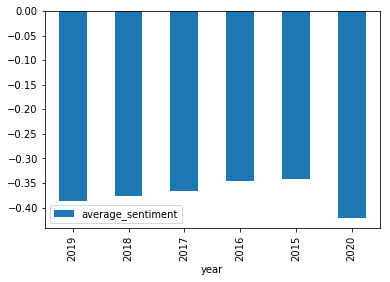

In [198]:
query = """
    SELECT 
        extract(year from date_received) as year, AVG(sentiment_score) as average_sentiment , COUNT(complaint_id) as total
    FROM 
        `nl_api.merged_data_with_sentiments`
    GROUP BY
       year
    ORDER BY
        total DESC
"""
query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

year_df = query_job.to_dataframe()
year_df.plot(kind='bar', x='year', y='average_sentiment')

In [197]:
year_df

,year,average_sentiment,total
0,2019,-0.387341,123841
1,2018,-0.376984,118492
2,2017,-0.365586,115176
3,2016,-0.345305,77820
4,2015,-0.341008,54753
5,2020,-0.421479,6637


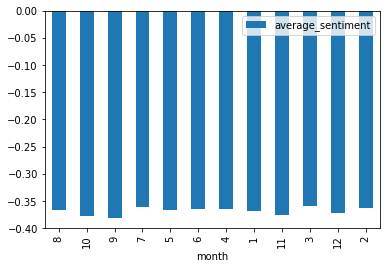

In [200]:
query = """
    SELECT 
        extract(month from date_received) as month, AVG(sentiment_score) as average_sentiment , COUNT(complaint_id) as total
    FROM 
        `nl_api.merged_data_with_sentiments`
    GROUP BY
       month
    ORDER BY
        total DESC
"""
query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

month_df = query_job.to_dataframe()
month_df.plot(kind='bar', x='month', y='average_sentiment')

In [215]:
month_df.sort_values(by='average_sentiment',ascending=True)
# Year ends have the worst complaints on average.

,month,average_sentiment,total
2,9,-0.380743,45417
1,10,-0.377397,45493
8,11,-0.375025,39544
10,12,-0.371500,38272
7,1,-0.368615,40186
0,8,-0.367227,45766
4,5,-0.366671,42420
6,4,-0.365553,40901
5,6,-0.364191,41085
11,2,-0.362817,34962


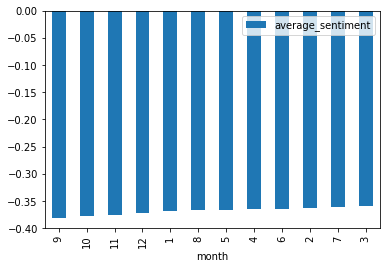

In [214]:
#Sorted plot
month_df.sort_values(by='average_sentiment',ascending=True).plot(kind='bar', x='month', y='average_sentiment')